# Extracting the Dataset

In [ ]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import librosa
import librosa.display
import io
import random

In [38]:
dataset_path = "Jzuluaga/uwb_atcc"
splits = [10,20,30,40,50,60,70,80,90,100]

# set i to the value you want to use then run notebook and gather results
# values 0 through 9 corresponding to the index of splits
i = 0


In [39]:
def extract(path, split_value):
    # load in huggingface dataset
    dataset = load_dataset(dataset_path, split=f"train[:{split_value}%]")
    
    # save out dataset (not sure if we want to save out the data)
    #if (split_value == 10):
    #    dataset.to_csv("/workspaces/aai-501-final/data/training_data10.csv")
    
    # convert dataset into pandas DataFrame
    data = dataset.to_pandas()
    
    # data should already be cleaned so this is a sanity check
    len1 = len(data)
    data = data.dropna()
    len2 = len(data)
    if (len1 != len2):
        print("WARNING - dataset had missing values")
    elif (len2 != data["id"].nunique()):
        print("WARNING - dataset has repeating id values")
    
    return data

In [40]:
# Create duration histogram
def duration_hist(df, name="10", save_path="../data/outputs/"):

    file_name = f"{save_path}duration_hist{name}.png"

    # histogram of duration
    cmap = plt.get_cmap("rainbow")
    sns.histplot(df["duration"], bins=30, color=cmap(0.55))

    plt.xlabel("Duration of Audio Clip (Seconds)")
    plt.ylabel("Frequency (# of occurrences)")
    plt.title(f"Distribution of Audio Durations - {name}% of Training data")
    
    plt.savefig(file_name)

In [41]:
data = extract(dataset_path, splits[i])


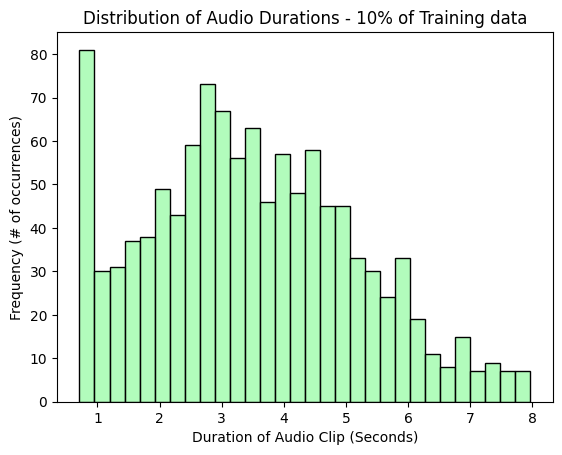

In [42]:
duration_hist(data, str(splits[i]))

In [43]:
# get total amount of data (add the durations)
sum = data["duration"].sum()

hours, r = divmod(sum, 3600)
mins, secs = divmod(r, 60)

print(f"Total duration ({splits[i]}% of Train): \nhrs:mins:secs= {int(hours):02}:{int(mins):02}:{int(secs):02}")

Total duration (10% of Train): 
hrs:mins:secs= 01:05:42


In [44]:
print(data.head())

                                        id  \
0    uwb-atcc_ACCU-0agmXf_000000_000395_AT   
1    uwb-atcc_ACCU-0agmXf_000479_000630_PI   
2    uwb-atcc_ACCU-0agmXf_000665_000738_PI   
3  uwb-atcc_ACCU-0agmXf_000964_001554_PIAT   
4    uwb-atcc_ACCU-0agmXf_001730_002224_AT   

                                               audio  \
0  {'bytes': b'RIFF\x04\xf7\x00\x00WAVEfmt \x10\x...   
1  {'bytes': b'RIFF\x84^\x00\x00WAVEfmt \x10\x00\...   
2  {'bytes': b'RIFF\xc4-\x00\x00WAVEfmt \x10\x00\...   
3  {'bytes': b'RIFF\xe4p\x01\x00WAVEfmt \x10\x00\...   
4  {'bytes': b'RIFFD4\x01\x00WAVEfmt \x10\x00\x00...   

                                                text  segment_start_time  \
0  sky shuttle one one four zero now descend flig...            0.000000   
1                      descending flight level three            4.790000   
2                                       k oscar zulu            6.650000   
3  austrian three two three golf climb flight lev...            9.640000   
4  sky

In [ ]:
def show_rand_elements(dataset):
    elements = []
    for _ in range(10):
        element = random.randint(0, len(dataset)-1)
        while element in elements:
            element = random.randint(0, len(dataset)-1)
        elements.append(element)
    
    rand_data = pd.DataFrame(dataset[elements])
    print(rand_data)

show_rand_elements(data)

In [45]:
# convert audio from bytes into a waveform
def bytes_to_waveform(audio):
    audio_io = io.BytesIO(audio)
    y, sr = librosa.load(audio_io, sr=None)
    # Resample the audio data
    y = librosa.resample(y, orig_sr=sr, target_sr=16000)
    
    # return audio signal (y) and the sampling rate (sr)
    return y, sr

In [46]:
def graph_spectogram(y, sr, name):
    spect = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
    
    plt.figure(figsize=(10, 10))
    librosa.display.specshow(spect, x_axis="time", y_axis="log", sr=sr, cmap="rainbow")
    plt.colorbar(format="%+2.0f dB")
    
    plt.title(f"Spectrogram for Data Entry {name}") 
    plt.xlabel("Time (s)") 
    plt.ylabel("Frequency (Hz)")
    
    plt.savefig(f"../data/outputs/{name}_spectrogram.png", dpi=300)
    plt.show()

In [47]:
def eda_features(y, sr):
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y).mean()
    rmse = librosa.feature.rms(y=y).mean()
    
    return {
        "spectral_centroid": spectral_centroid,
        "spectral_bandwidth": spectral_bandwidth,
        "zero_crossing_rate": zero_crossing_rate,
        "rmse": rmse
    }

/tmp/ipykernel_10289/1699354880.py:2: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  spect = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


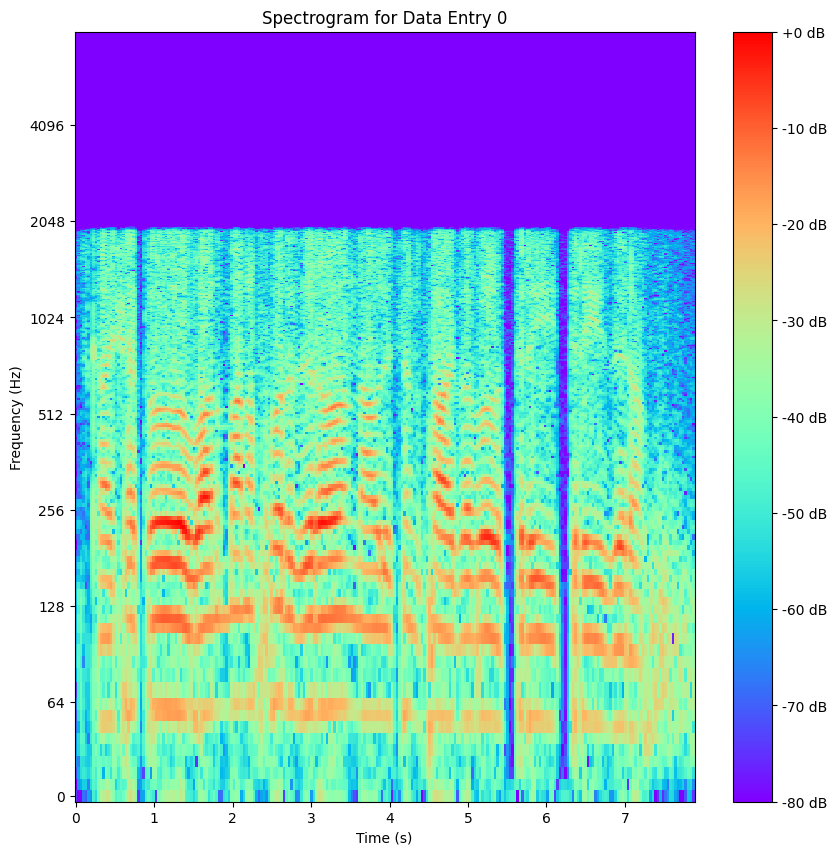

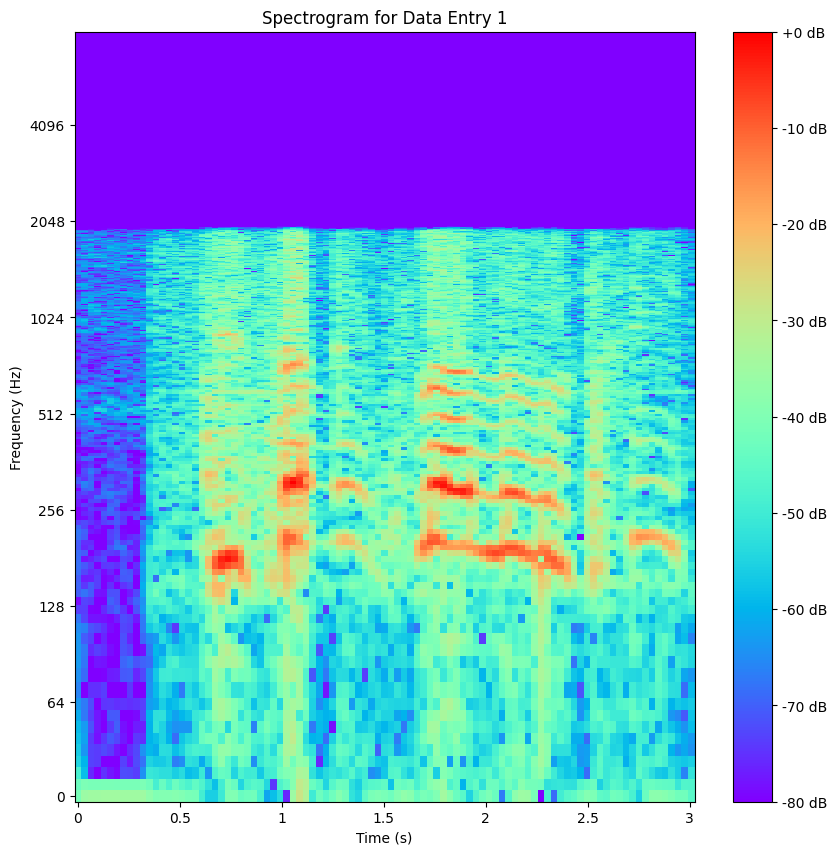

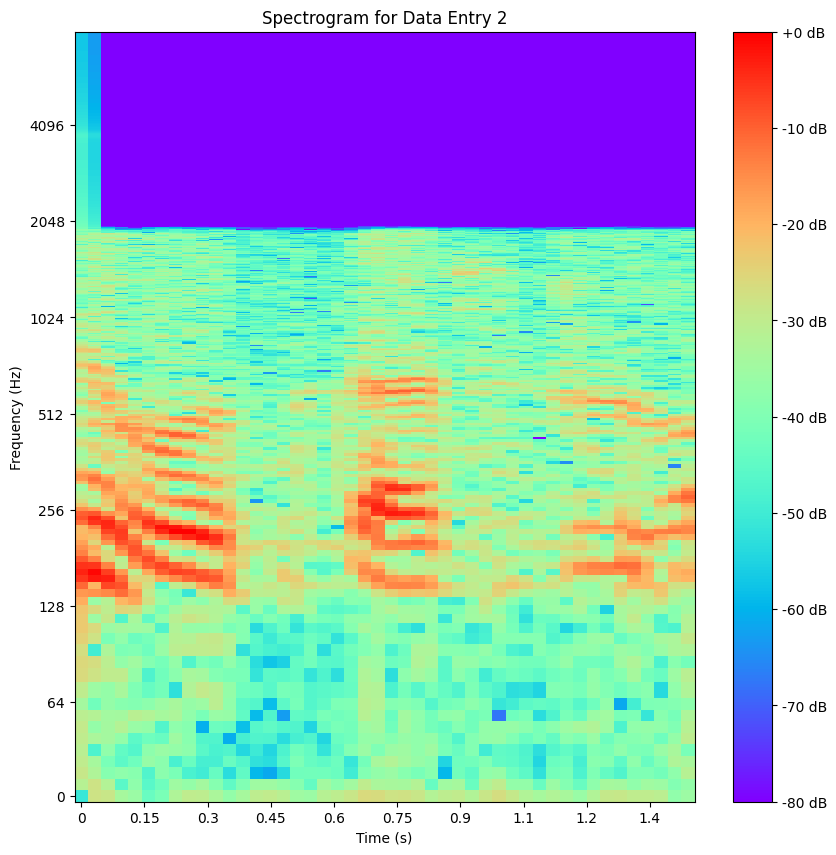

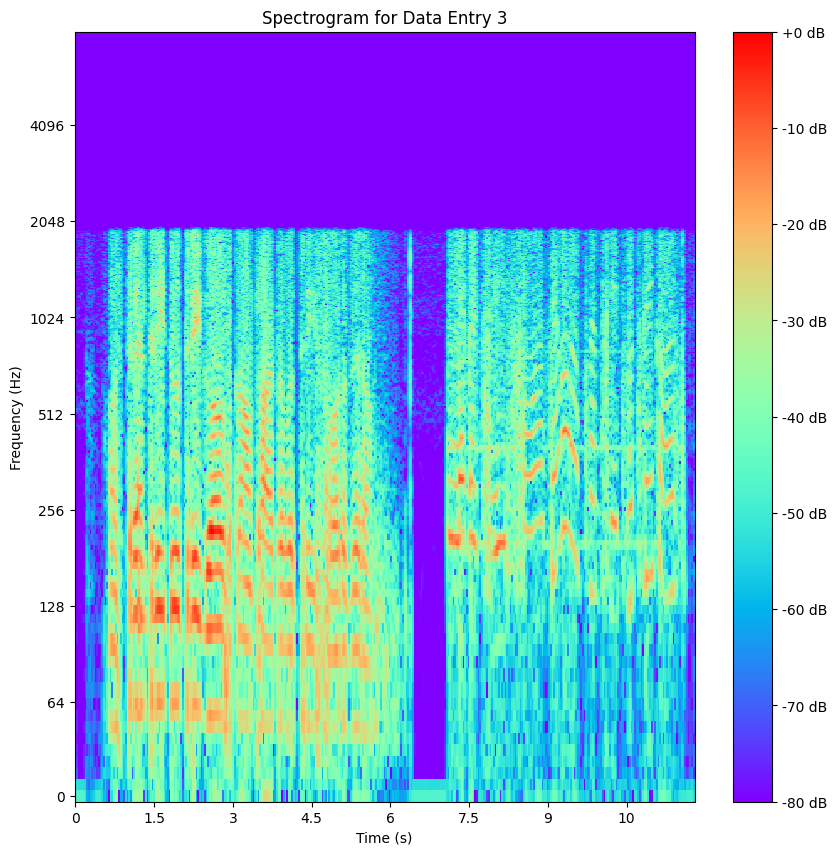

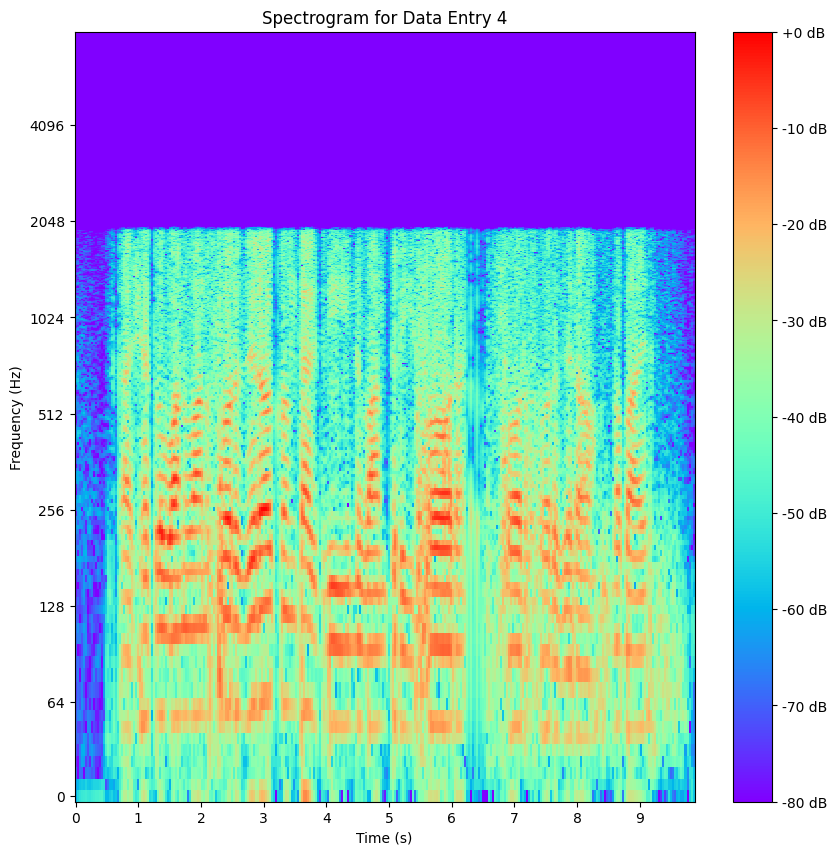

In [48]:
# processing dataframe for EDA
audio_features = []
for index, row in data.iterrows():
    audio_bytes = row["audio"]["bytes"]
    y, sr = bytes_to_waveform(audio_bytes)
    # Resample the audio data
    y_resampled = librosa.resample(y, orig_sr=sr, target_sr=16000)

    # Compute the STFT and convert to decibels using the magnitude
    spect = librosa.amplitude_to_db(np.abs(librosa.stft(y_resampled)), ref=np.max)
    
    # generate only a few spectograms
    if index < 5:
        spectogram = graph_spectogram(y_resampled, 16000, index)
    
    # Extract audio features
    features = eda_features(y_resampled, 16000)
    audio_features.append(features)

In [49]:
# add features to the data
features = pd.DataFrame(audio_features)
data_features = pd.concat([data, features], axis=1)

print(data_features.describe())


       segment_start_time  segment_end_time     duration  spectral_centroid  \
count         1129.000000       1129.000000  1129.000000        1129.000000   
mean            31.734493         35.226707     3.492214         688.198339   
std             41.211510         41.111725     1.679190          87.968125   
min              0.000000          1.530000     0.710000         462.227198   
25%              6.180000          9.290000     2.280000         627.972248   
50%             16.620001         20.450001     3.400000         693.044361   
75%             39.970001         43.865002     4.640000         753.619396   
max            266.649994        267.589996     7.970000         932.357697   

       spectral_bandwidth  zero_crossing_rate         rmse  
count         1129.000000         1129.000000  1129.000000  
mean           493.615004            0.066644     0.023730  
std             21.546936            0.017861     0.012058  
min            437.102610            0.02700

<Figure size 1000x1000 with 0 Axes>

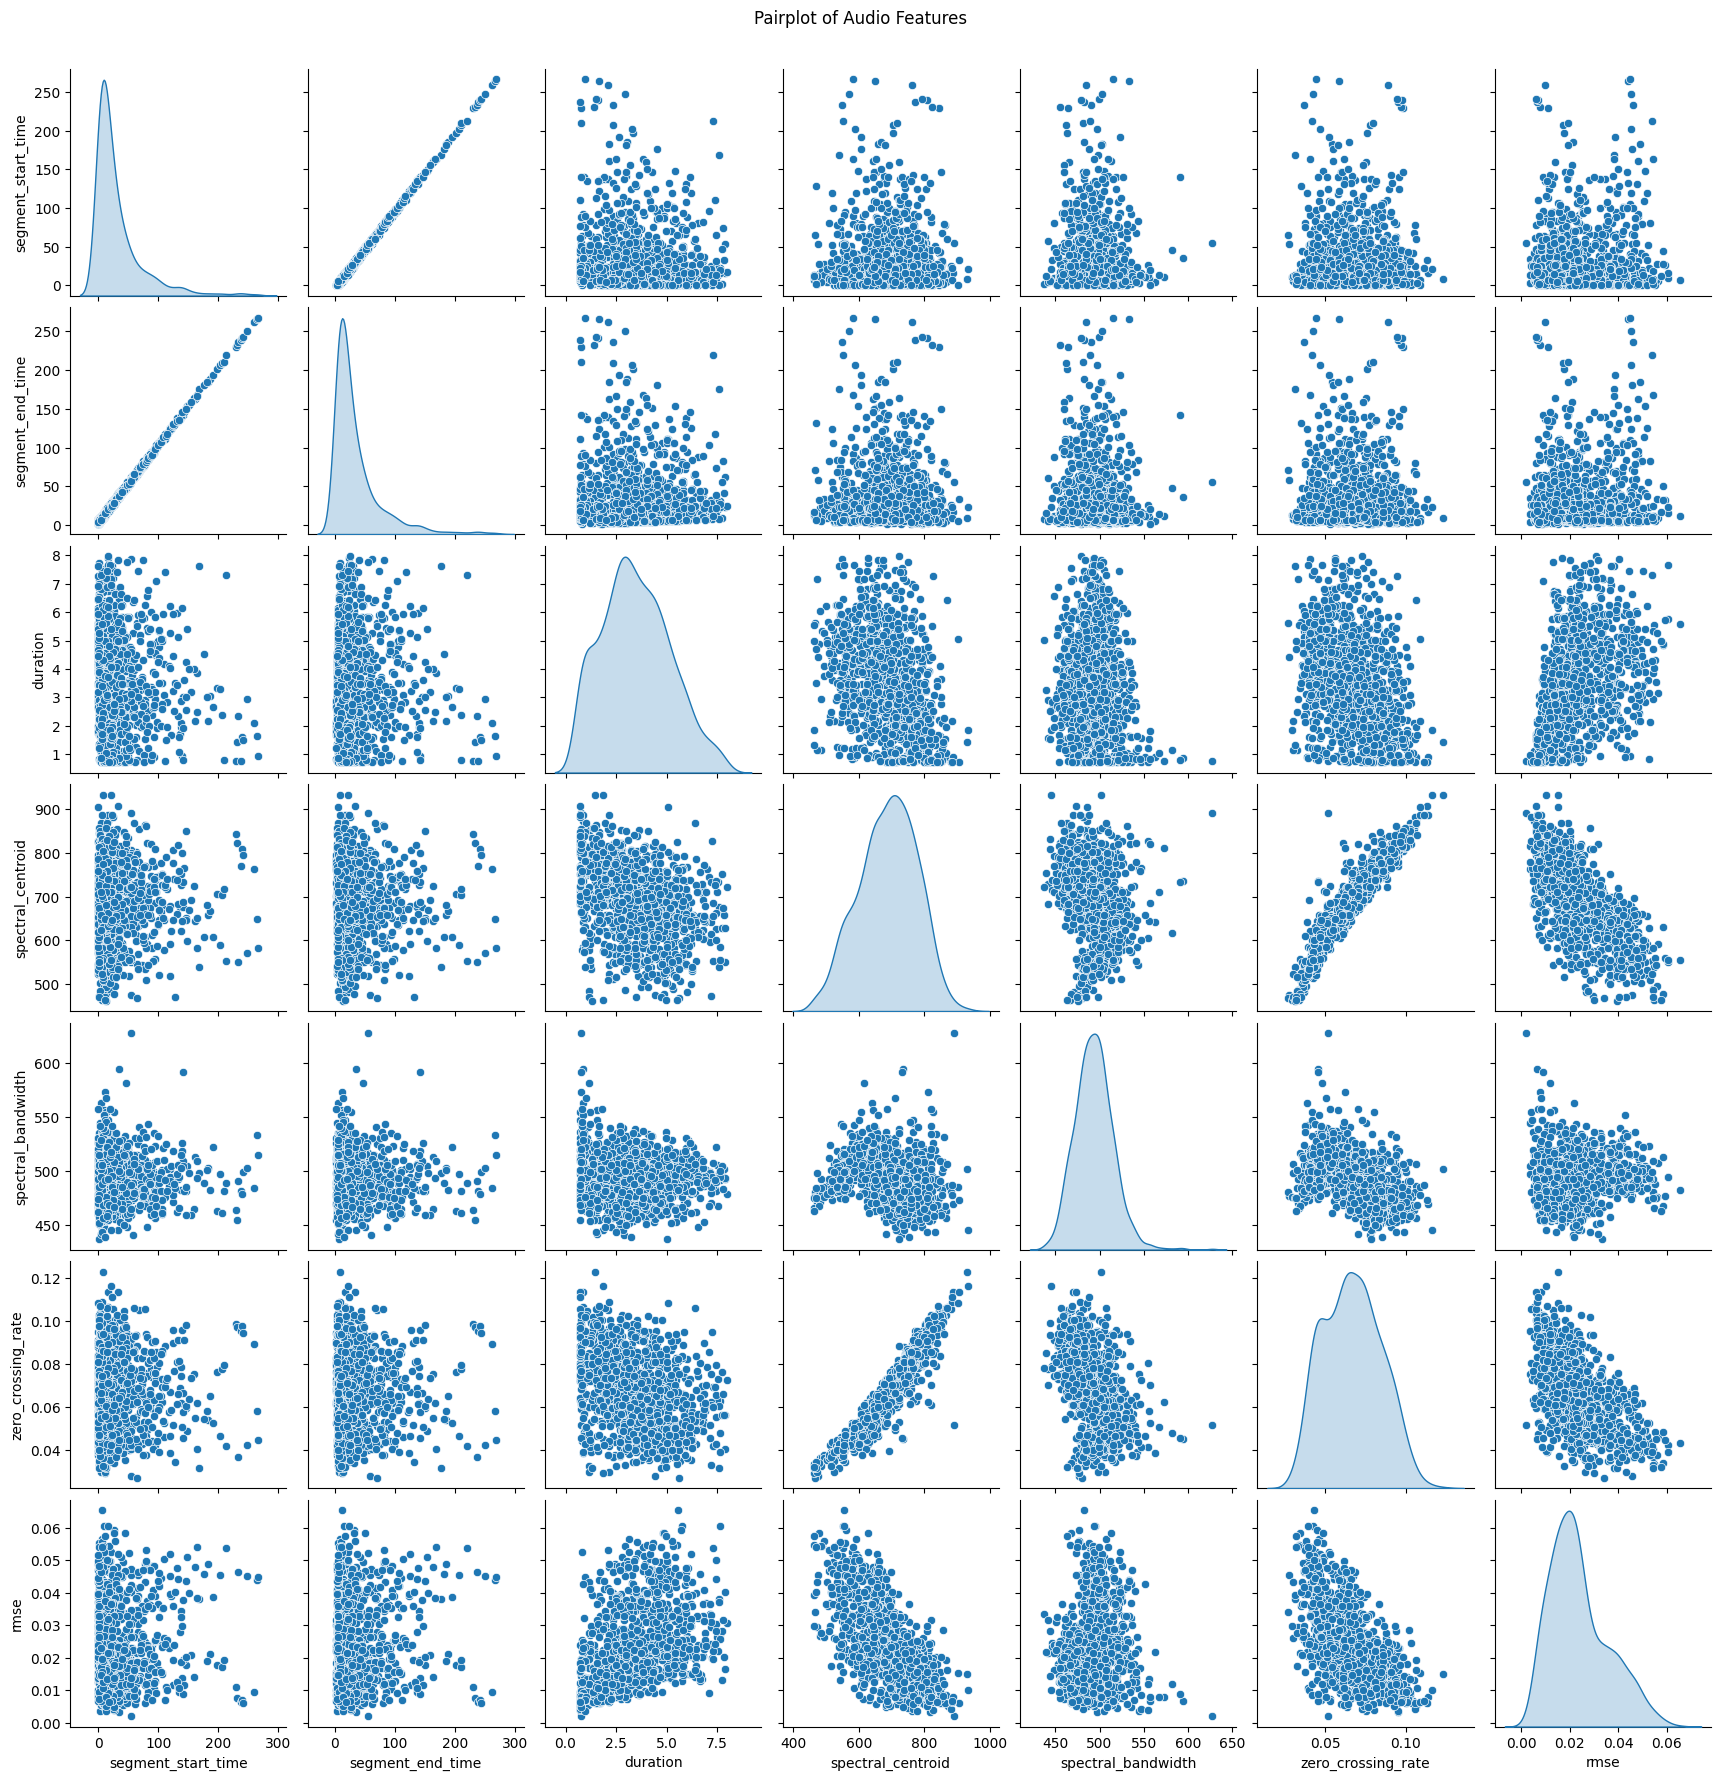

In [50]:
# pair plot graph - 
plt.figure(figsize=(10, 10))
sns.pairplot(data_features.drop('audio', axis=1), diag_kind='kde')
plt.suptitle('Pairplot of Audio Features', y=1.02)
plt.show()

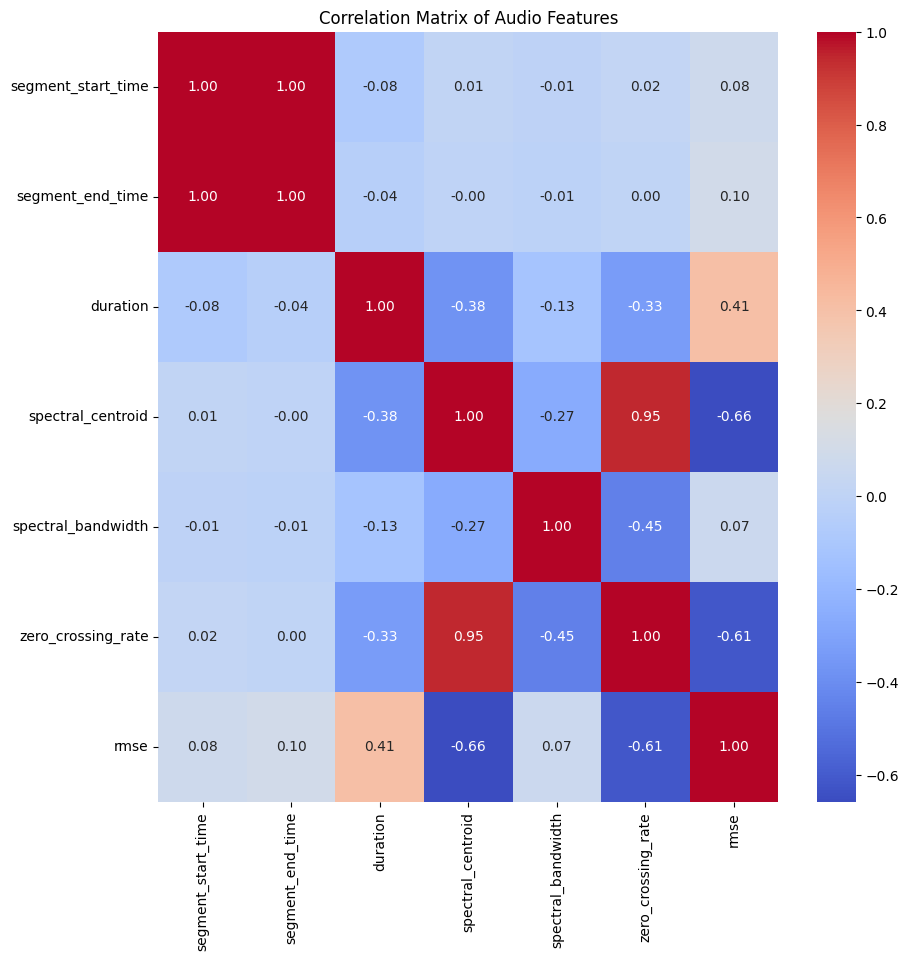

In [51]:
# Heatmap to show correlation between features
plt.figure(figsize=(10, 10))
sns.heatmap(data_features.drop('audio', axis=1).select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Audio Features')
plt.show()

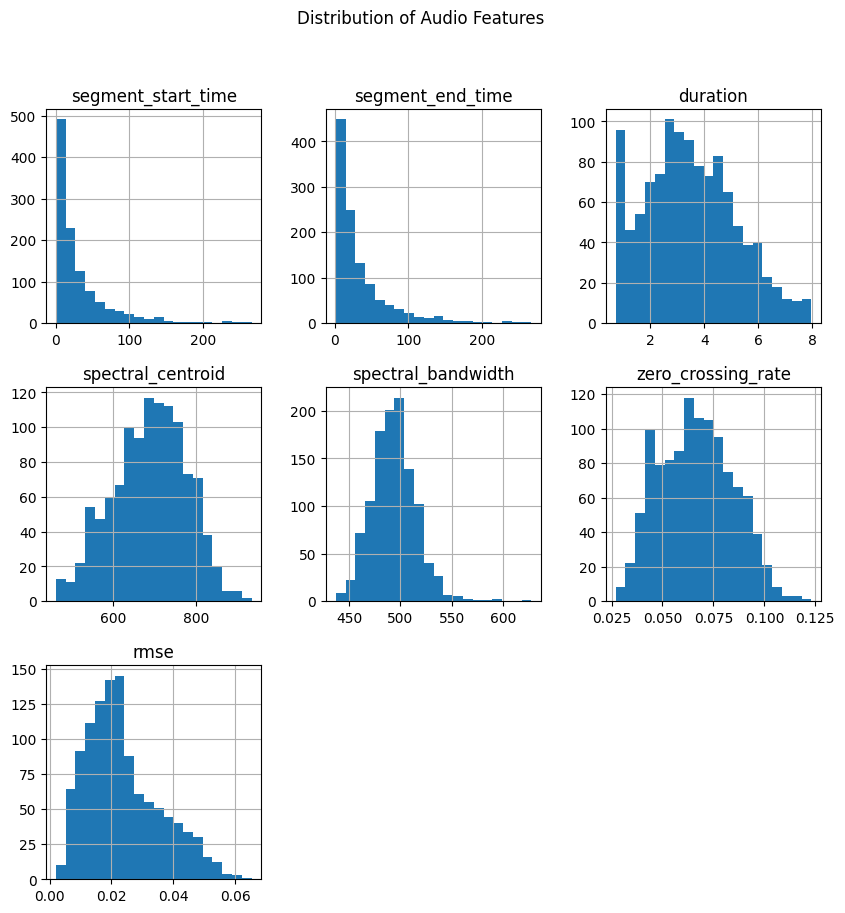

In [52]:
# histograms for features
data_features.drop('audio', axis=1).hist(bins=20, figsize=(10, 10))
plt.suptitle('Distribution of Audio Features')
plt.show()

In [61]:
# allows us to use data variable in another notebook 
import pickle

with open('../data/train_data.pkl', 'wb') as f:
    pickle.dump(data, f)